In [1]:
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import os
import numpy as np
from PIL import Image
import cv2
from pystackreg import StackReg
import pandas as pd
import math
import matplotlib.pyplot as plt
import pyFAI
import copy
from mypackages.edp_processing import ImageAnalysis, ImageProcessing

In [2]:
roi = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Fe2O3_OAm/Fe2O3_OAm_ROI1/Fe2O3_OAm_ROI1_2.tiff'
path = os.path.join(sys.path[-1], roi)

process = ImageProcessing(path)
image = process.load_images(num_images=1)

2308 1978


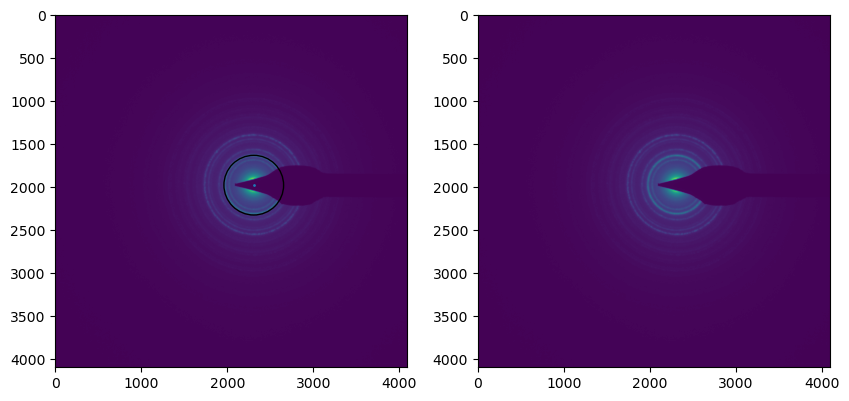

In [3]:
from matplotlib.patches import Circle

analysis = ImageAnalysis()
center_x, center_y, r = analysis.find_center(image, 1, 5000, 60, 255, 10)

circle1 = Circle((center_x, center_y), r,  fill = False )

#center_x, center_y = 2266, 1983
print(center_x, center_y)

f, ax = plt.subplots(1,2, figsize = (10,20))
ax[0].imshow(image)
ax[0].scatter(center_x, center_y, s=1)
ax[0].add_patch(circle1)
ax[1].imshow(image)

  File "/tmp/ipykernel_3195/834652677.py", line 11, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)


360.47348828633767 221.1677950404365


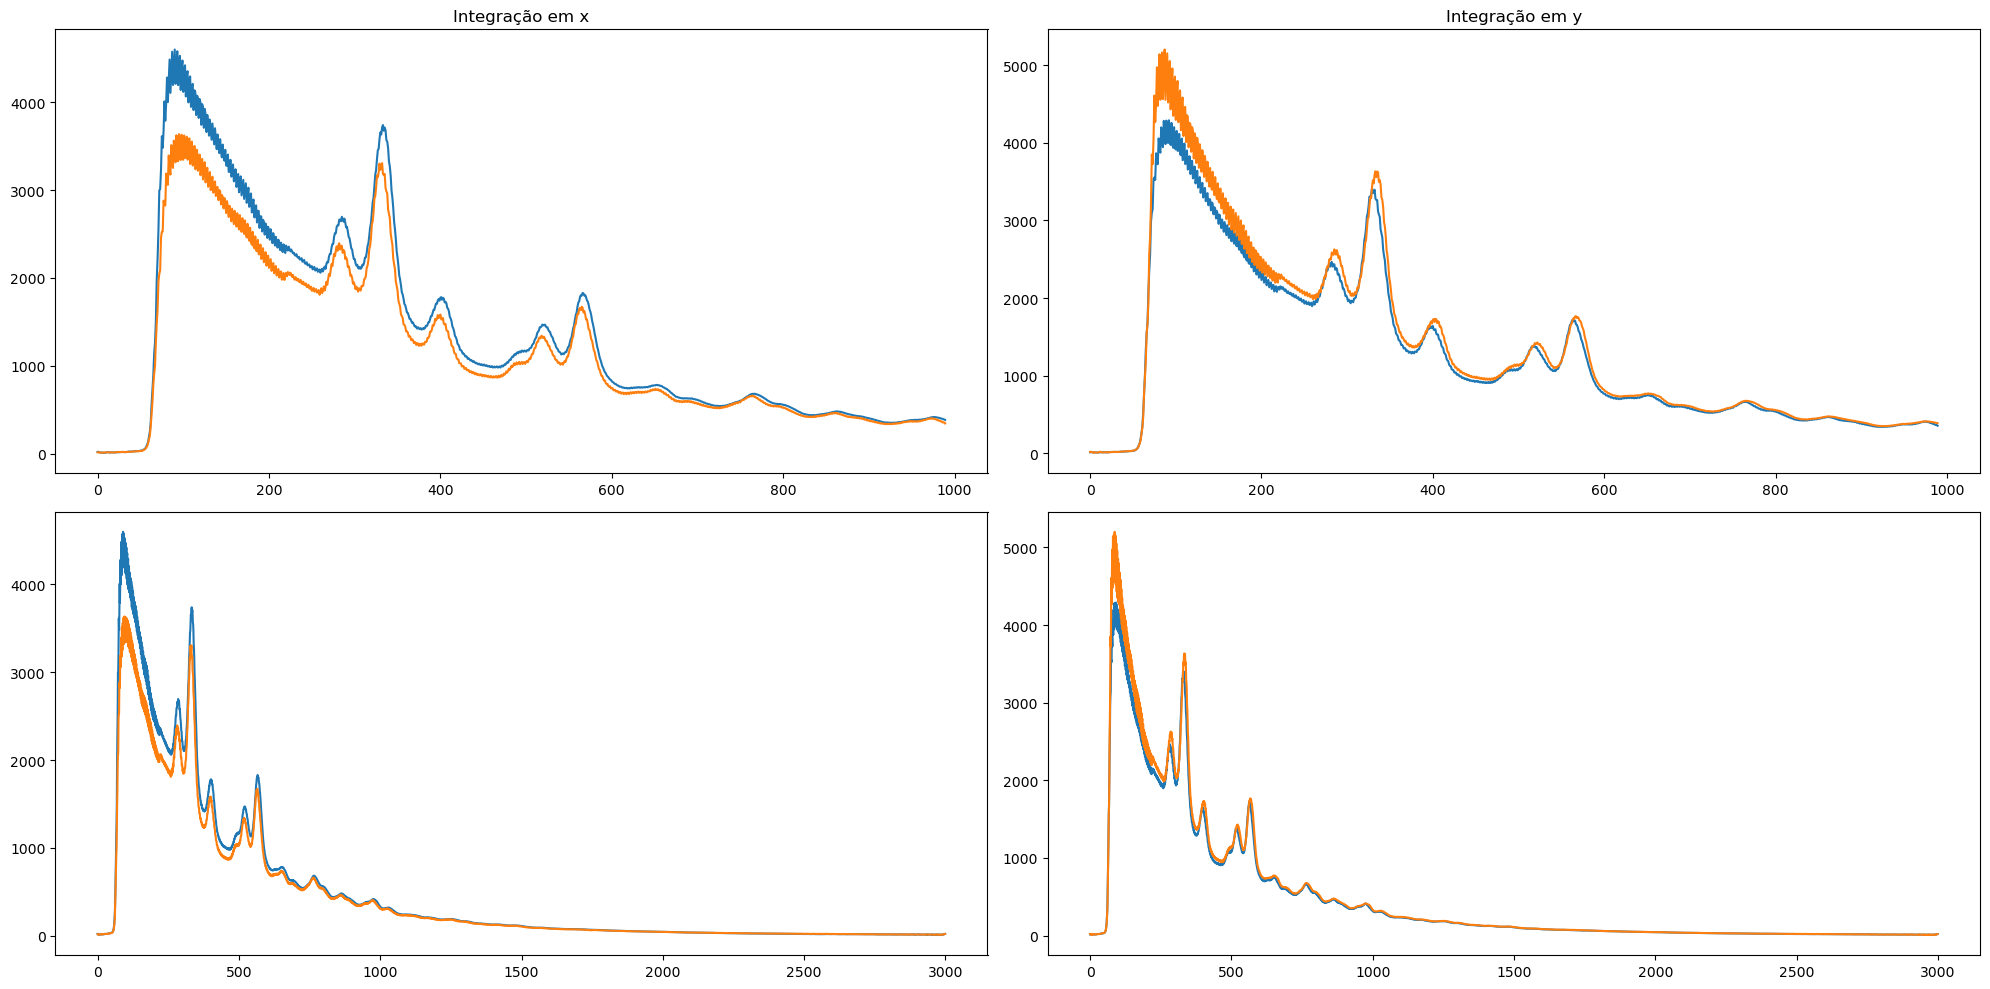

In [4]:
#@title 1.4. Testes com o centro obtido pela transformada de Hough

binning = 3000

azimuth_ranges_set1 = [(89, 91), (-91, -89)]
azimuth_ranges_set2 = [(-50, -48), (129, 131)]
#center_x, center_y = analysis.optimize_center(image, center_x, center_y, azimuth_ranges_set1 + azimuth_ranges_set2, max_iterations = 20)

center_x, center_y = 2310, 1986

ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)
stacked1= image

res1 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(305, 325), method = "ocl_lut_integr")
res2 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(125, 145), method = "ocl_lut_integr")
res3 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(80, 100), method = "ocl_lut_integr")
res4 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(-100, -80), method = "ocl_lut_integr")

res1, res2 = np.array(res1), np.array(res2)
res3, res4 = np.array(res3), np.array(res4)

pico_x = np.argmax(res1[1][100:500]), np.argmax(res2[1][100:500])

erro_x = analysis.MSE(res1[1][100:500], res2[1][100:500])
erro_y = analysis.MSE(res3[1][100:500], res4[1][100:500])
print(erro_x, erro_y)

best_error = 1000000

if (erro_x+erro_y) < best_error:
  best_error = erro_x + erro_y
  best_centro = [center_x, center_y]

fig,ax= plt.subplots(2,2,figsize=(20, 10))

ax[0, 0].set_title('Integração em x')
ax[0, 0].plot(res1[1][0:int(0.33*binning)])
ax[0, 0].plot(res2[1][0:int(0.33*binning)])
#ax[0, 0].text(200, 0.5 * res3[1][100:600].max(), f'Melhor erro: {best_error:.2f} com centro 'f'{best_centro}', fontsize=12, color='red')
#ax[0, 0].text(200, 0.4 * res3[1][100:600].max(), f'EQM: {(erro_x + erro_y):.2f} com centro 'f'{center_x, center_y}', fontsize=12, color='red')

ax[0, 1].set_title('Integração em y')
#ax[0, 1].set_xlim(0, 500)
ax[0, 1].plot(res3[1][0:int(0.33*binning)])
ax[0, 1].plot(res4[1][0:int(0.33*binning)])

ax[1, 0].plot(res1[1])
ax[1, 0].plot(res2[1])

ax[1, 1].plot(res3[1])
ax[1, 1].plot(res4[1])

plt.tight_layout()
plt.show()


In [5]:
def create_circular_mask(height, width, center=None, radius=None):
    if center is None:  # use the middle of the image if no center is specified
        center = (int(width/2), int(height/2))
    if radius is None:  # use the smallest distance between the center and image walls if no radius is specified
        radius = min(center[0], center[1], width-center[0], height-center[1])

    Y, X = np.ogrid[:height, :width]
    distance_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = distance_from_center <= radius
    return mask


mask1 = create_circular_mask(image.shape[0], image.shape[1], (center_x, center_y), 2048)
mask2 = create_circular_mask(image.shape[0], image.shape[1], (center_x, center_y), 1598)
mask3 = create_circular_mask(image.shape[0], image.shape[1], (center_x, center_y), 1148)
mask4 = create_circular_mask(image.shape[0], image.shape[1], (center_x, center_y), 598)
mask5 = create_circular_mask(image.shape[0], image.shape[1], (center_x, center_y), 148)


first_region = image[~mask1]
second_region = image[np.logical_and(mask1,np.logical_not(mask2))]
third_region = image[np.logical_and(mask2, np.logical_not(mask3))]
fourth_region = image[np.logical_and(mask3, np.logical_not(mask4))]
fifth_region = image[np.logical_and(mask4, np.logical_not(mask5))]

In [7]:
means = [first_region.mean(),second_region.mean(), third_region.mean(), fourth_region.mean(), fifth_region.mean()]
maxes = [first_region.max(),second_region.max(), third_region.max(), fourth_region.max(), fifth_region.max()]
st_devs = [first_region.std(),second_region.std(), third_region.std(), fourth_region.std(), fifth_region.std()]

data = {
    'Mean': means,
    'Max': maxes,
    'Standard Deviation': st_devs
}

index_names = ['First Region', 'Second Region', 'Third Region', 'Fourth Region', 'Fifth Region']

# Create the DataFrame
df = pd.DataFrame(data, index=index_names)
df

,Mean,Max,Standard Deviation
First Region,26.947065,334,17.159751
Second Region,58.960723,455,22.833342
Third Region,136.011493,450,49.803464
Fourth Region,418.466612,1722,205.003650
Fifth Region,1520.431034,7992,1009.581342


In [13]:
first_region.shape

(3997274,)

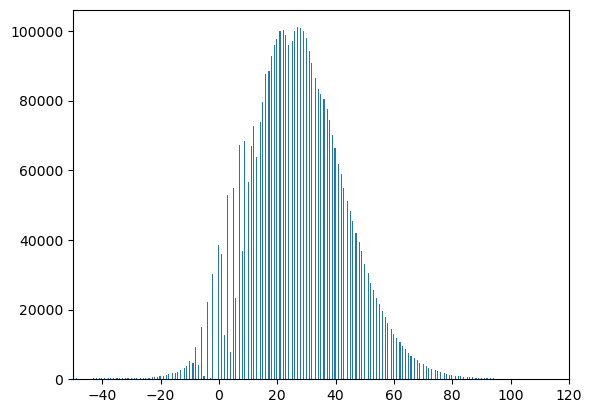

In [33]:
plt.hist(first_region, bins = 'scott')
plt.xlim(-50,120)
plt.show()

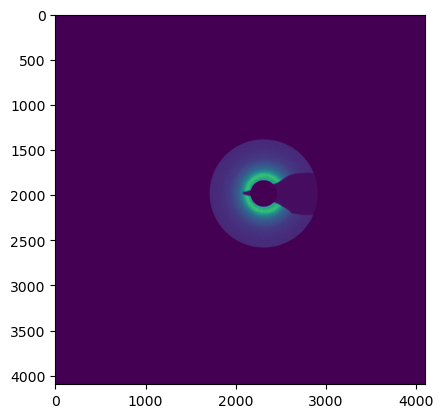

In [36]:
new_image = np.zeros_like(image)

# Now, apply the composite mask to copy only the pixels of interest
new_image[np.logical_and(mask4, np.logical_not(mask5))] = image[np.logical_and(mask4, np.logical_not(mask5))]
plt.imshow(new_image)

In [38]:
new_image.max()

65534